### Дано: 
стоимость премиум-подписки поменяли для 2х платежных систем; стоимость пробного периода оставили как есть. 

### Вопросы:
1. Эксперимент был успешен? Мб для каких-то конкретных групп?

### Алгоритм:
1. Подсчитать каунт новых покупок в новой схеме версус старой, подумать про градацию или когортный анализ. 
2. Статистически определить значимое ли отклонение. 

## 1. Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm
from datetime import date
from tqdm.auto import tqdm

## 2. Импортируем и изучаем данные

#### 2.1 Импортируем данные

In [2]:
# сеты юзеров
df_ut = pd.read_csv("users_test.csv", sep=';').fillna(0) # test
df_uc_1 = pd.read_csv("users_control_1.csv", sep=';').fillna(0) # control 1
df_uc_2 = pd.read_csv("users_control_2.csv", sep=';').fillna(0) # control 2

# сеты транзакций
df_trnsct = pd.read_csv("transactions_test.csv", sep=';').fillna(0) # test 
df_tc_1 = pd.read_csv("transactions_control_1.csv", sep=';').fillna(0) # control 1
df_tc_2 = pd.read_csv("transactions_control_2.csv", sep=';').fillna(0) # control 2

#### 2.2 Смотрим на df

In [3]:
df_ut.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0


In [4]:
df_ut.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [10]:
df_trnsct.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [58]:
df_trnsct.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

#### 2.3 Объединяем данные по юзерам и транзакциям

In [3]:
# Добавляем в данные столбец 'group_type', чтобы при объединении таблиц мы знали где тестовая, а где контрольные группы.

df_ut = df_ut.assign(group_type = 'test')
df_uc_1 = df_uc_1.assign(group_type = 'control_1')
df_uc_2 = df_uc_2.assign(group_type = 'control_2')

df_trnsct = df_trnsct.assign(group_type = 'test')
df_tc_1 = df_tc_1.assign(group_type = 'control_1')
df_tc_2 = df_tc_2.assign(group_type = 'control_2')

In [4]:
users        = pd.concat([df_ut, df_uc_1, df_uc_2])
transactions = pd.concat([df_trnsct, df_tc_1, df_tc_2])

In [9]:
users.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group_type
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test


In [16]:
users.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
group_type           object
dtype: object

In [10]:
transactions.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group_type
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test


In [17]:
transactions.dtypes

uid             float64
country          object
joined_at        object
paid_at          object
revenue         float64
payment_id      float64
from_page        object
product_type     object
group_type       object
dtype: object

In [5]:
# приведем к общему типу данных uid, а также переведем joined/paid в тип datetime

transactions.uid       = transactions.uid.astype('int64')
transactions.joined_at = pd.to_datetime(transactions.joined_at)
transactions.paid_at   = pd.to_datetime(transactions.paid_at)

#### 2.4 Смотрим полученные датасеты на предмет max/min/mean значений

In [11]:
users.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,1.291200e+04,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000
mean,8.917569e+08,32.010378,315.455545,9.070864,0.955158,26.815985,38.568463,46.641032,0.097196,0.041822,526.837283
std,1.610285e+06,10.224415,323.488766,883.417344,0.206965,9.447197,15.511204,285.324194,0.296236,0.200189,5524.662716
min,8.910509e+08,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913565e+08,25.000000,0.000000,0.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917255e+08,30.000000,250.000000,0.000000,1.000000,25.000000,35.000000,6.000000,0.000000,0.000000,0.000000
75%,8.920860e+08,38.000000,529.000000,0.000000,1.000000,32.000000,45.000000,21.000000,0.000000,0.000000,0.000000
max,1.053059e+09,99.000000,1000.000000,99958.000000,1.000000,96.000000,102.000000,16157.000000,1.000000,1.000000,486330.000000


In [12]:
transactions.describe()

,uid,revenue,payment_id
count,1.608000e+03,1608.000000,1608.000000
mean,5.425412e+08,4277.145522,57.531716
std,4.355910e+08,7572.460420,64.604663
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000
50%,8.913498e+08,1456.000000,19.000000
75%,8.920051e+08,6292.000000,147.000000
max,9.609370e+08,113477.000000,147.000000


In [7]:
# проверим датасет с транзакциями на предмет наличия дублей
transactions.duplicated().sum()

662

In [6]:
# Удаляем строки без транзакций и дубликаты
transactions.drop_duplicates(inplace=True)
transactions.dropna(inplace=True)

In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945 entries, 0 to 327
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           945 non-null    int64         
 1   country       945 non-null    object        
 2   joined_at     945 non-null    datetime64[ns]
 3   paid_at       945 non-null    datetime64[ns]
 4   revenue       945 non-null    float64       
 5   payment_id    945 non-null    float64       
 6   from_page     945 non-null    object        
 7   product_type  945 non-null    object        
 8   group_type    945 non-null    object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 73.8+ KB


#### 2.5 Проверим выбросы

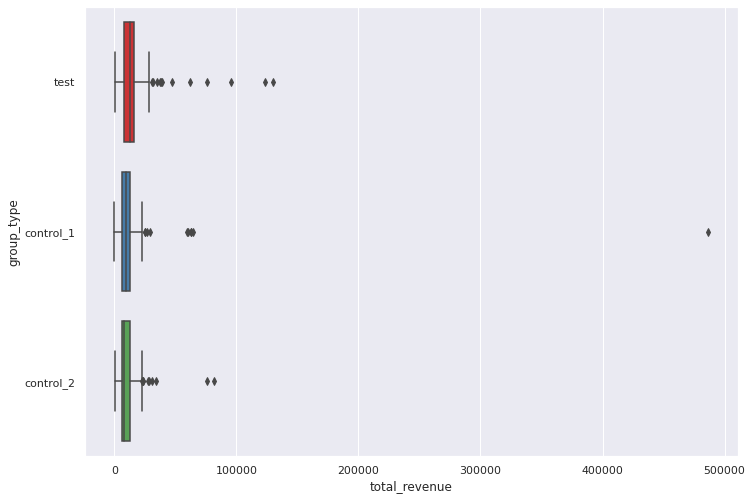

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="total_revenue", y="group_type", data=users.query('total_revenue > 0'), orient="h", palette="Set1")

In [ ]:
# видим выброс в 1й контрольной группе, найдем его и удалим

In [10]:
users.query('group_type == "control_1"').total_revenue.max()

486330

In [11]:
users.query('total_revenue == 486330')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group_type
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,control_1


In [9]:
users = users.drop(labels = [1427],axis = 0)

In [25]:
# удалим также его из df с транзакциями

In [13]:
transactions.query('uid == 892333905')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group_type
6,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins,control_1
13,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,control_1
28,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,control_1
43,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,control_1
49,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,control_1
63,892333905,Italy,2017-10-16 01:38:00,2017-10-16 22:35:00,31525.0,19.0,menu,coins,control_1
76,892333905,Italy,2017-10-16 01:38:00,2017-10-16 18:42:00,31525.0,19.0,fans,coins,control_1
126,892333905,Italy,2017-10-16 01:38:00,2017-10-16 22:39:00,19773.0,146.0,menu,coins,control_1
137,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,31525.0,19.0,gifts,coins,control_1
143,892333905,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial,control_1


In [10]:
transactions = transactions.drop(labels = [6,13,28,43,49,63,76,126,137,143,149,166,256,289,297,306,316,335,358],axis = 0)

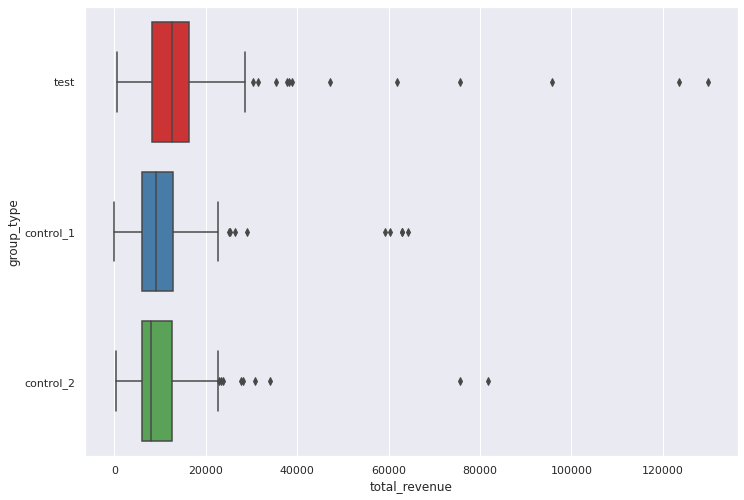

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="total_revenue", y="group_type", data=users.query('total_revenue > 0'), orient="h", palette="Set1")

#### данные подготовили, можно приступать к анализу

## 3. Анализ данных

#### 3.1 Посчитаем ARPPU

In [12]:
arppu_test = users.query('group_type == "test" and total_revenue > 0').total_revenue.sum() / users.query('group_type == "test" and total_revenue > 0').uid.nunique()
arppu_con1 = users.query('group_type == "control_1" and total_revenue > 0').total_revenue.sum() / users.query('group_type == "control_1" and total_revenue > 0').uid.nunique()
arppu_con2 = users.query('group_type == "control_2" and total_revenue > 0').total_revenue.sum() / users.query('group_type == "control_2" and total_revenue > 0').uid.nunique()

print(arppu_test)
print(arppu_con1)
print(arppu_con2)


15759.027397260274
10968.256544502618
10269.72192513369


#### 3.2 Посчитаем ARPU

In [13]:
arpu_test = users.query('group_type == "test"').total_revenue.sum() / users.query('group_type == "test"').uid.nunique()
arpu_con1 = users.query('group_type == "control_1"').total_revenue.sum() / users.query('group_type == "control_1"').uid.nunique()
arpu_con2 = users.query('group_type == "control_2"').total_revenue.sum() / users.query('group_type == "control_2"').uid.nunique()

print(arpu_test)
print(arpu_con1)
print(arpu_con2)

534.2043185511957
482.81562572021204
450.48979591836735


In [ ]:
# ARPU и ARPPU наибольшие в тестовой группе.

#### 3.3 Доля платящих пользователей

In [14]:
pay_test = arpu_test/arppu_test
pay_con1 = arpu_con1/arppu_con1
pay_con2 = arpu_con2/arppu_con2

print(pay_test)
print(pay_con1)
print(pay_con2)

0.03389830508474576
0.04401935929937774
0.04386582219094534


In [ ]:
# несмотря на наибольшие показатели по ARPU и ARPPU доля платящих в тестовой группе наименьшая. 

#### 3.4 Посчитаем LTV

In [14]:
lt_test = df_trnsct.value_counts("uid").mean()
lt_test

1.86986301369863

In [15]:
lt_con1 = df_tc_1.value_counts("uid").mean()
lt_con1

5.190721649484536

In [16]:
lt_con2 = df_tc_2.value_counts("uid").mean()
lt_con2

1.7540106951871657

In [ ]:
# считаем LTV= arpu*lifetime

In [17]:
ltv_test = lt_test*arpu_test
ltv_test

998.8888970169618

In [18]:
ltv_con1 = lt_con1*arpu_con1
ltv_con1

2506.1615211353273

In [19]:
ltv_con2 = lt_con1*arpu_con2
ltv_con2

2338.3671365453397

In [ ]:
# LTV наибольший в контрольных группах

#### 3.5 Посчитаем retention

In [20]:
df_ut.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})

uid    251
dtype: int64

In [21]:
ret_test = df_ut.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})/df_ut.query("was_premium == 1.0 or is_premium == 1.0").agg({'uid':'count'})
ret_test

uid    0.615196
dtype: float64

In [22]:
df_uc_1.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})

uid    244
dtype: int64

In [23]:
ret_con1 = df_uc_1.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})/df_uc_1.query("was_premium == 1.0 or is_premium == 1.0").agg({'uid':'count'})
ret_con1

uid    0.559633
dtype: float64

In [24]:
df_uc_2.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})

uid    220
dtype: int64

In [25]:
ret_con2 = df_uc_2.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})/df_uc_2.query("was_premium == 1.0 or is_premium == 1.0").agg({'uid':'count'})
ret_con2

uid    0.53528
dtype: float64

In [26]:
ret_test-ret_con1


uid    0.055563
dtype: float64

In [27]:
ret_test-ret_con2

uid    0.079916
dtype: float64

In [ ]:
# наибольший отток в тестовой выборке, при этом в сравнении со 2й контрольной группой он выше на почти 8%

#### 3.6 Посчитать процент перехода из trial в premium;

In [28]:
df_test_is_was = df_ut.query("was_premium == 1.0 and is_premium == 1.0").agg({'uid':'count'})/df_ut.query("was_premium == 1.0 or is_premium == 1.0").agg({'uid':'count'})
df_test_is_was

uid    0.384804
dtype: float64

In [29]:
df_ut.query("was_premium == 0 and is_premium == 1.0").agg({'uid':'count'})

uid    0
dtype: int64

In [30]:
df_ut.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})

uid    251
dtype: int64

In [31]:
df_ut.query("was_premium == 1.0 and is_premium == 1.0").agg({'uid':'count'})

uid    157
dtype: int64

In [32]:
df_uc_1.query("was_premium == 0 and is_premium == 1.0").agg({'uid':'count'})

uid    0
dtype: int64

In [33]:
df_uc_1.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})

uid    244
dtype: int64

In [34]:
df_uc_1.query("was_premium == 1.0 and is_premium == 1.0").agg({'uid':'count'})

uid    192
dtype: int64

In [35]:
df_con1_is_was = df_uc_1.query("was_premium == 1.0 and is_premium == 1.0").agg({'uid':'count'})/df_uc_1.query("was_premium == 1.0 or is_premium == 1.0").agg({'uid':'count'})
df_con1_is_was

uid    0.440367
dtype: float64

In [36]:
df_uc_2.query("was_premium == 0 and is_premium == 1.0").agg({'uid':'count'})

uid    0
dtype: int64

In [37]:
df_uc_2.query("was_premium == 1.0 and is_premium == 0").agg({'uid':'count'})

uid    220
dtype: int64

In [38]:
df_uc_2.query("was_premium == 1.0 and is_premium == 1.0").agg({'uid':'count'})

uid    191
dtype: int64

In [39]:
df_con2_is_was = df_uc_2.query("was_premium == 1.0 and is_premium == 1.0").agg({'uid':'count'})/df_uc_2.query("was_premium == 1.0 or is_premium == 1.0").agg({'uid':'count'})
df_con2_is_was

uid    0.46472
dtype: float64

In [ ]:
# ВЫВОД: в контрольных группах выше процент перехода из trial в premium на 6 и 8% соответственно


#### 3.7 Посмотреть сезонность подключений к премиуму


In [40]:
transactions.query('group_type == "test"').paid_at.max() - transactions.query('group_type == "test"').paid_at.min()


Timedelta('334 days 17:29:00')

In [41]:
transactions.query('group_type == "test"').paid_at.dt.month.value_counts()

10    138
11     26
5      12
4      12
3      11
7      10
2      10
12      9
6       8
9       7
8       6
1       4
Name: paid_at, dtype: int64

In [42]:
transactions.query('group_type == "control_1"').paid_at.max() - transactions.query('group_type == "control_1"').paid_at.min()


Timedelta('362 days 05:41:00')

In [43]:
transactions.query('group_type == "control_1"').paid_at.dt.month.value_counts()

10    164
11     37
6      22
12     20
5      20
4      17
7      13
9      11
8      11
1      10
2       7
3       5
Name: paid_at, dtype: int64

In [44]:
transactions.query('group_type == "control_2"').paid_at.max() - transactions.query('group_type == "control_2"').paid_at.min()


Timedelta('334 days 17:54:00')

In [45]:
transactions.query('group_type == "control_2"').paid_at.dt.month.value_counts()

10    168
11     28
6      17
8      14
5      14
3      13
4      12
2      11
7      10
9       9
12      7
1       3
Name: paid_at, dtype: int64

In [ ]:
# В целом везде взяты примерно равные промежутки времени для анализа, отличий в части сезонности не выявлено - везде наибольший результат дает октябрь.

#### 3.8 Посмотрим данные в разрезе стран


In [ ]:
# Сформируем df, в котором будут присутстсовать только те страны, которые есть в тестовой группе и обеих контрольных.

In [46]:
df_countries = users.groupby(['group_type', 'country'], as_index = False).agg({'total_revenue':'sum', 'uid':'count'})

In [47]:
test_countries = list(df_countries.query('group_type == "test"').country)
c1_countries = list(df_countries.query('group_type == "control_1"').country)
c2_countries = list(df_countries.query('group_type == "control_2"').country)

set(test_countries) & set(c1_countries) & set(c2_countries)

{'Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'France',
 'Germany',
 'India',
 'Israel',
 'Italy',
 'Kyrgyzstan',
 'Mexico',
 'Peru',
 'Portugal',
 'Russian Federation',
 'Spain',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America'}

In [48]:
# модифицируем список стран согласно полученному результату выше
df_countries = df_countries.query("country == ['Argentina', 'Australia', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Dominican Republic',  'France', 'Germany', 'India', 'Israel', 'Italy', 'Kyrgyzstan', 'Mexico', 'Peru', 'Portugal', 'Russian Federation', 'Spain', 'Switzerland', 'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom (Great Britain)', 'United States of America']")

In [49]:
df_countries.groupby(['group_type', 'country']) \
                .agg({'total_revenue': 'sum'}) \
                .reset_index() \
                .pivot(index='country', columns='group_type', values='total_revenue') \
                .sort_values('test', ascending = False)

group_type,control_1,control_2,test
country,,,
United States of America,713687,584207,721838
Spain,99060,193778,285428
France,184353,149071,253617
United Arab Emirates,75543,117143,213785
Argentina,144690,121017,188019
Italy,147368,118989,113425
Germany,23998,71409,96096
Israel,118391,68926,94809
United Kingdom (Great Britain),198965,96473,77376


##### Total_revenue больше в тестовой группе в сравнении с контрольными в Испании, Франции, Аргентине, Мексике, ОАЭ, Германии, США.

## 4. A/A тест

In [ ]:
# проверим корректность работы системы сплитования

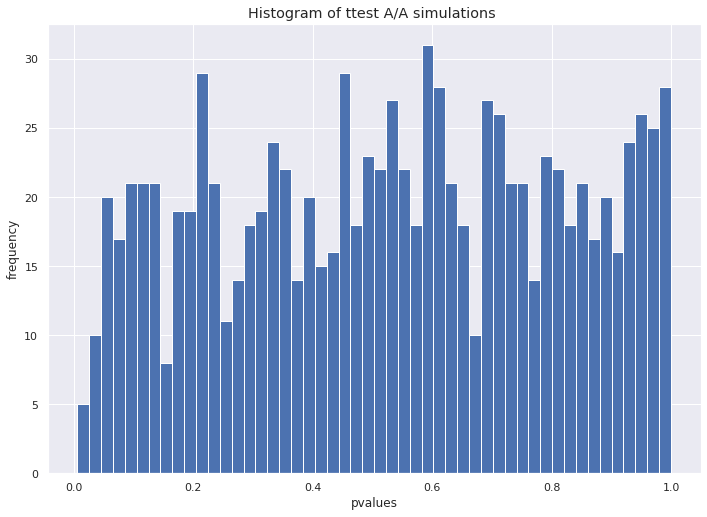

0.017

In [15]:
n = 100000
simulations = 1000
n_s = 1000
res = []
c1 = users.query('group_type == "control_1"')
c2 = users.query('group_type == "control_2"')


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = c1.total_revenue.sample(n_s, replace = False).values
    s2 = c2.total_revenue.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

статзначимых различий не выявлено -> считаем, что система работает корректно.

## 5. A/B тест

#### 5.1 Провера на нормальность распредления с помощью теста Шапиро-Уилка

H0 - заключается в том, что случайная величина, выборка x которой известна, распределена по нормальному закону.

H1 - заключается в том, что распределени не является нормальным

In [19]:
stats.shapiro(users.query('group_type == "control_1"').total_revenue)

ShapiroResult(statistic=0.14440131187438965, pvalue=0.0)

In [20]:
stats.shapiro(users.query('group_type == "control_2"').total_revenue)

ShapiroResult(statistic=0.144597589969635, pvalue=0.0)

In [24]:
stats.shapiro(users.query('group_type == "test"').total_revenue)

ShapiroResult(statistic=0.09915435314178467, pvalue=0.0)

In [22]:
stats.shapiro(users.query('group_type == "control_1" and total_revenue > 0').total_revenue)

ShapiroResult(statistic=0.6391915082931519, pvalue=6.679394912190761e-20)

In [23]:
stats.shapiro(users.query('group_type == "control_2" and total_revenue > 0').total_revenue)

ShapiroResult(statistic=0.6258848905563354, pvalue=5.0175247612037996e-20)

In [25]:
stats.shapiro(users.query('group_type == "test" and total_revenue > 0').total_revenue)

ShapiroResult(statistic=0.5494610071182251, pvalue=2.530081054497636e-19)

Вывод: P-value<0,05. Отклоняем H0. Распределения не являются нормальными

#### 5.2 Проверим выборки на равенство дисперсий при помощи теста Левена.

H0 - дисперсии в сравниваемых группах гомогенны

H1 - дисперсии в сравниваемых группах отличаются

In [26]:
stats.levene(users.query('group_type == "control_1"').total_revenue,users.query('group_type == "test"').total_revenue )

LeveneResult(statistic=0.4005569210591971, pvalue=0.5268185218398728)

In [27]:
stats.levene(users.query('group_type == "control_2"').total_revenue,users.query('group_type == "test"').total_revenue )

LeveneResult(statistic=1.097981148844328, pvalue=0.2947391421702294)

p-value в обоих случаях > 0.05. Следовательно дисперсии в сравниваемых группах однородны.

#### 5.3 Гипотезы и метрики

#### Для проведения А/В теста определимся с метриками, которые мы хотим исследовать:
1. ARPU - изменится ли среднее ARPU на пользователя при эксперименте с платежной системой;
2. ARPPU - изменится ли среднее ARPPU на пользователя при эксперименте с платежной системой;
3. CR - повысится ли конверсия в покупку при эксперименте с платежной системой.

Воспользуемся бутстрэпом для проверки стат.значимости различий наших метрик потому, что данные не распределены нормально; бутстреп лучше теста Манна-Уитни работает с большим количеством повторяющихся значений (у нас много нулей в неплатящих пользователях); легко интерпретируем.

In [28]:
# Бутсрэп-функция
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

### 5.4 ARPU

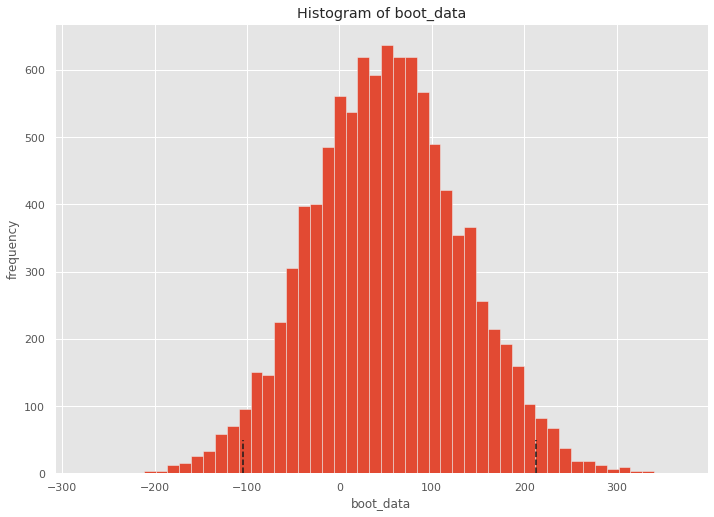

p-value =  0.5272

                0
0.025 -104.233919
0.975  213.229886


In [31]:
boot_arpu_t_vs_c1 = get_bootstrap(users.query('group_type == "test"').drop_duplicates('uid').total_revenue,\
              users.query('group_type == "control_1"').drop_duplicates('uid').total_revenue, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_arpu_t_vs_c1['p_value'].round(4))
print('')
print(boot_arpu_t_vs_c1['ci'])

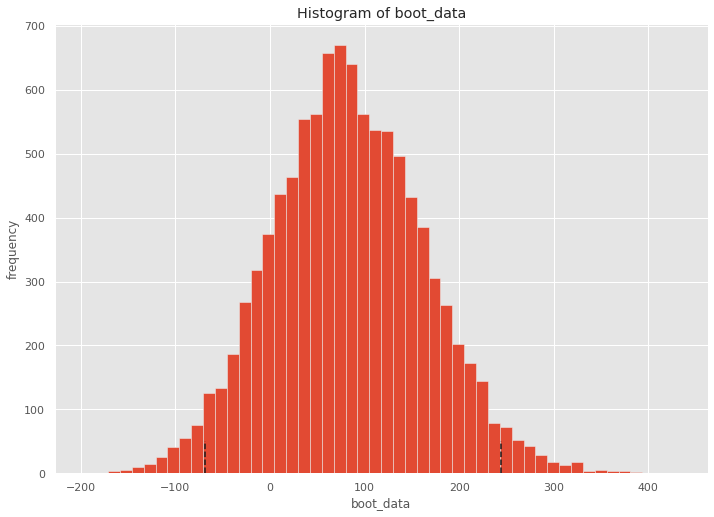

p-value =  0.2995

                0
0.025  -68.352322
0.975  244.321070


In [56]:
boot_arpu_t_vs_c2 = get_bootstrap(users.query('group_type == "test"').drop_duplicates('uid').total_revenue,\
              users.query('group_type == "control_2"').drop_duplicates('uid').total_revenue, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_arpu_t_vs_c2['p_value'].round(4))
print('')
print(boot_arpu_t_vs_c2['ci'])

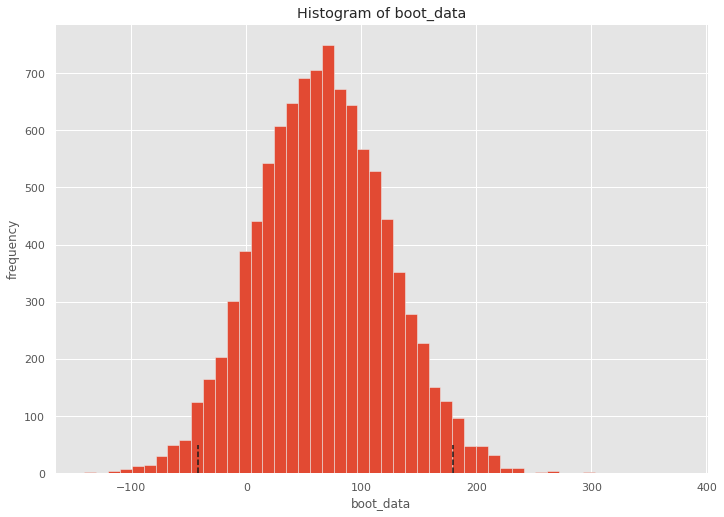

p-value =  0.2457

                0
0.025  -41.854083
0.975  179.363276


In [30]:
boot_arpu_t_vs_c = get_bootstrap(users.query('group_type == "test"').drop_duplicates('uid').total_revenue,\
              users.query('group_type == "control_1" or group_type == "control_2"').drop_duplicates('uid').total_revenue, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_arpu_t_vs_c['p_value'].round(4))
print('')
print(boot_arpu_t_vs_c['ci'])

Значимых отличий по ARPU нет.

### 5.5 ARPPU

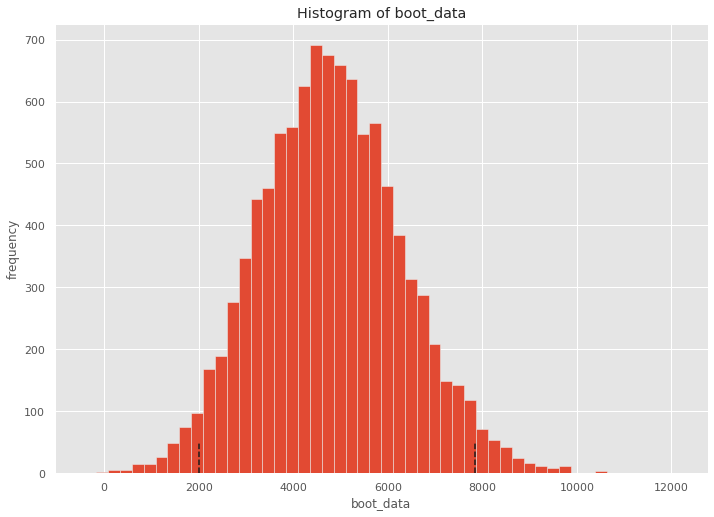

p-value =  0.0014

                 0
0.025  2005.658377
0.975  7856.095681


In [60]:
boot_arppu_t_vs_c1 = get_bootstrap(users.query('group_type == "test" and total_revenue > 0').drop_duplicates('uid').total_revenue,\
              users.query('group_type == "control_1" and total_revenue > 0').drop_duplicates('uid').total_revenue, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_arppu_t_vs_c1['p_value'].round(4))
print('')
print(boot_arppu_t_vs_c1['ci'])

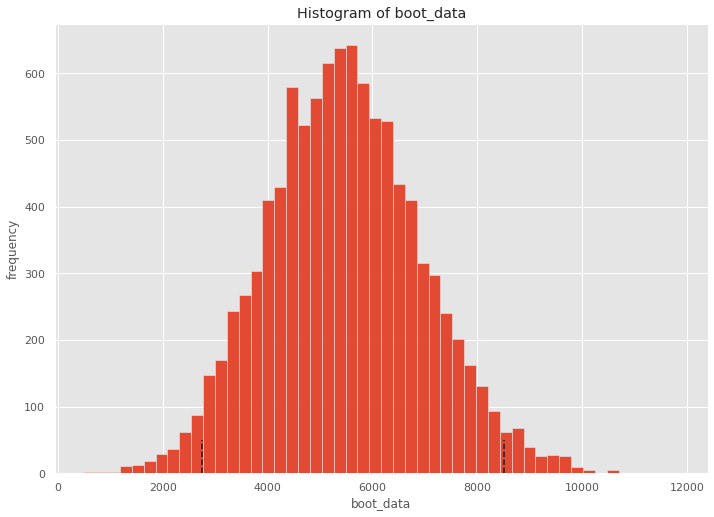

p-value =  0.0002

                 0
0.025  2740.203610
0.975  8504.671257


In [59]:
boot_arppu_t_vs_c2 = get_bootstrap(users.query('group_type == "test" and total_revenue > 0').drop_duplicates('uid').total_revenue,\
              users.query('group_type == "control_2" and total_revenue > 0').drop_duplicates('uid').total_revenue, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_arppu_t_vs_c2['p_value'].round(4))
print('')
print(boot_arppu_t_vs_c2['ci'])

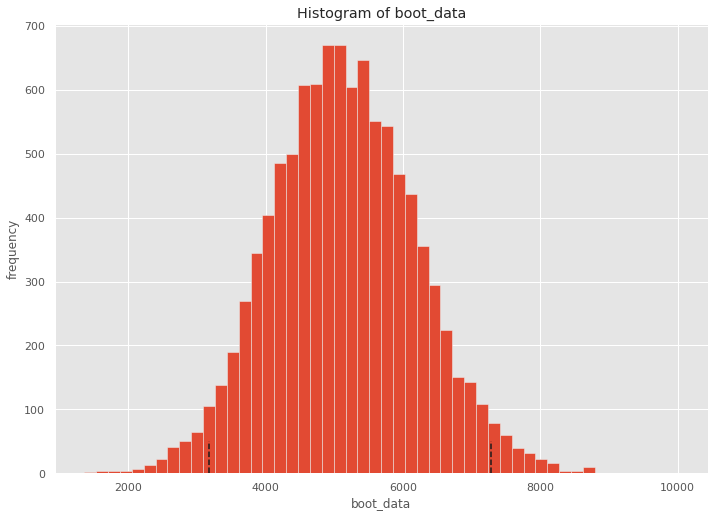

p-value =  0.0

                 0
0.025  3173.569974
0.975  7280.056746


In [35]:
boot_arppu_t_vs_c = get_bootstrap(users.query('group_type == "test" and total_revenue > 0').drop_duplicates('uid').total_revenue,\
              users.query('(group_type == "control_2" or group_type == "control_1") and total_revenue > 0').drop_duplicates('uid').total_revenue, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_arppu_t_vs_c['p_value'].round(4))
print('')
print(boot_arppu_t_vs_c['ci'])

In [70]:
users.query('total_revenue > 0').drop_duplicates('uid')\
                            .groupby('group_type', as_index=False)\
                            .agg({'total_revenue':'mean'})

,group_type,total_revenue
0,control_1,10968.256545
1,control_2,10269.721925
2,test,15759.027397


p-value меньше уровня значимости, значит применяем альтернативную гипотезу, что есть стат.значимые отличия - ARPPU значимо вырос в тестовой группе. 

### 5.4 CR

In [61]:
# для упрощения работы создадим столбец с фактором наличия платной подписки

In [38]:
transactions['premium'] = transactions.product_type.apply(lambda x: 1 if x == 'premium_no_trial' else 0)

In [39]:
df_all = pd.merge(users, transactions, how='left')

In [50]:
df_all = df_all.fillna(0)

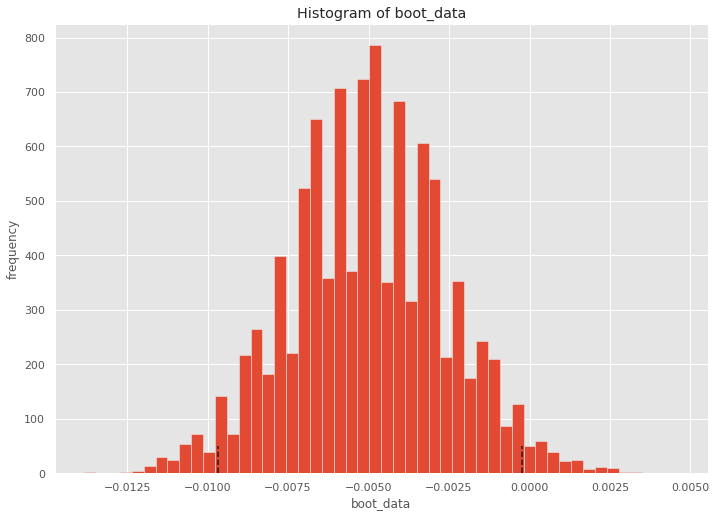

p-value =  0.0407

             0
0.025 -0.00968
0.975 -0.00023


In [52]:
boot_cr_t_vs_c1 = get_bootstrap(df_all.query('group_type == "test"').drop_duplicates('uid').premium,\
              df_all.query('group_type == "control_1"').drop_duplicates('uid').premium, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_cr_t_vs_c1['p_value'].round(4))
print('')
print(boot_cr_t_vs_c1['ci'])

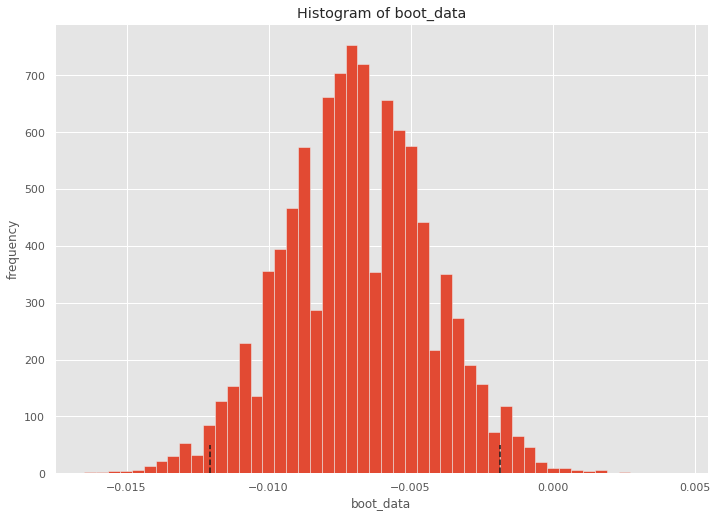

p-value =  0.0074

              0
0.025 -0.012073
0.975 -0.001857


In [53]:
boot_cr_t_vs_c2 = get_bootstrap(df_all.query('group_type == "test"').drop_duplicates('uid').premium,\
              df_all.query('group_type == "control_2"').drop_duplicates('uid').premium, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_cr_t_vs_c2['p_value'].round(4))
print('')
print(boot_cr_t_vs_c2['ci'])

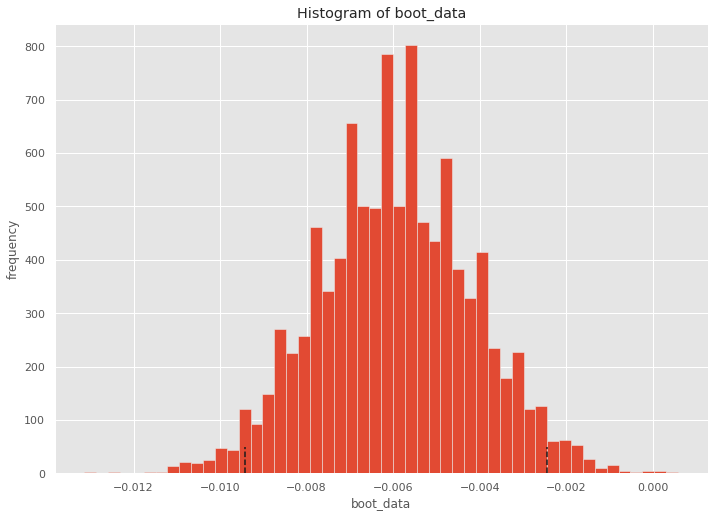

p-value =  0.0009

              0
0.025 -0.009416
0.975 -0.002441


In [54]:
boot_cr_t_vs_c = get_bootstrap(df_all.query('group_type == "test"').drop_duplicates('uid').premium,\
              df_all.query('group_type == "control_1" or group_type == "control_2"').drop_duplicates('uid').premium, \
              statistic=np.mean, boot_it = 10000)
print('p-value = ', boot_cr_t_vs_c['p_value'].round(4))
print('')
print(boot_cr_t_vs_c['ci'])

In [73]:
transactions.drop_duplicates('uid').groupby('group_type').agg({'premium':'mean'})

,premium
group_type,
control_1,0.359375
control_2,0.422222
test,0.340580


конверсия значимо снизилась в тестовой группе

### 5.5 Анализ по странам

Ранее уже было проведено сравнение по странам в разрезе total_revenue, сравним в рамках указанных выше метрик. Чтобы не анализировать все ограничимся ТОП5 стран по количеству оформленных платных подписок.

In [76]:
transactions.drop_duplicates('uid').groupby('country', as_index=False)\
.agg({'premium':'sum'})\
.sort_values('premium', ascending=False)\
.query('premium > 10').country.to_list()

['United States of America',
 'France',
 'Spain',
 'Italy',
 'United Kingdom (Great Britain)',
 'Argentina',
 'United Arab Emirates']

In [78]:
# ARPU
users.query("country == 'United States of America'\
         or country == 'France'\
         or country == 'Spain'\
         or country == 'Italy'\
         or country == 'United Kingdom (Great Britain)'\
         or country == 'Argentina'\
         or country == 'United Arab Emirates'")\
        .drop_duplicates('uid')\
        .pivot_table(index = 'country' , columns = 'group_type', values='total_revenue', aggfunc='mean')\
        .dropna()\
        .sort_values('test', ascending = False)

group_type,control_1,control_2,test
country,,,
Spain,289.649123,625.090323,948.265781
United Arab Emirates,364.942029,555.180095,945.951327
France,498.251351,396.465426,706.454039
United States of America,485.171312,393.405387,498.162871
Argentina,371.953728,304.828715,474.795455
United Kingdom (Great Britain),1362.773973,660.773973,457.846154
Italy,437.293769,406.105802,351.160991


In [79]:
# ARPPU
users.query('total_revenue > 0')\
        .query("country == 'United States of America'\
         or country == 'France'\
         or country == 'Spain'\
         or country == 'Italy'\
         or country == 'United Kingdom (Great Britain)'\
         or country == 'Argentina'\
         or country == 'United Arab Emirates'")\
        .drop_duplicates('uid')\
        .pivot_table(index = 'country' , columns = 'group_type', values='total_revenue', aggfunc='mean')\
        .dropna()\
        .sort_values('test', ascending = False)

group_type,control_1,control_2,test
country,,,
Argentina,12057.500000,12101.700000,26859.857143
United Arab Emirates,10791.857143,23428.600000,23753.888889
France,8379.681818,7845.842105,19509.000000
Spain,11006.666667,16148.166667,19028.533333
United States of America,12096.389831,9128.234375,13881.500000
Italy,9210.500000,7436.812500,12602.777778
United Kingdom (Great Britain),19896.500000,9647.300000,9672.000000


In [81]:
# CR
transactions.query("country == 'United States of America'\
         or country == 'France'\
         or country == 'Spain'\
         or country == 'Italy'\
         or country == 'United Kingdom (Great Britain)'\
         or country == 'Argentina'\
         or country == 'United Arab Emirates'")\
        .drop_duplicates('uid')\
        .pivot_table(index = 'country' , columns = 'group_type', values='premium', aggfunc='mean')\
        .dropna()\
        .sort_values('test', ascending = False)

group_type,control_1,control_2,test
country,,,
United Arab Emirates,0.285714,0.800000,0.625000
Argentina,0.250000,0.500000,0.571429
Italy,0.437500,0.266667,0.555556
United Kingdom (Great Britain),0.300000,0.600000,0.500000
Spain,0.444444,0.636364,0.400000
United States of America,0.266667,0.409836,0.250000
France,0.454545,0.388889,0.166667


#### Видим, что ARPU значимо увеличилось для Испании ОАЭ, Франции (уменьшилось для Италии и Великобритании); ARPPU значимо увеличилось для Аргентины и Франции (уменьшилось для Великобритании в сравнении с 1й контрольной группой); конверсия повысилась для Аргентины и Италии.

### 5.6 Анализ по возрасту

In [17]:
# для начала сгруппируем пользователей в несколько групп по возрастам:

df1 = users.query('age < 19')
df1['age_group'] = '16-18'
df2 = users.query('age > 18 and age < 25')
df2['age_group'] = '19-25'
df3 = users.query('age > 25 and age < 36')
df3['age_group'] = '26-35'
df4 = users.query('age > 35 and age < 46')
df4['age_group'] = '36-45'
df5 = users.query('age > 45')
df5['age_group'] = '45+'

df_age = pd.concat([df1, df2, df3, df4, df5])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Посчитаем значения наших 3х метрик для разных возрастных групп пользователей

In [20]:
# ARPU
df_age.drop_duplicates('uid')\
        .pivot_table(index = 'age_group' , columns = 'group_type', values='total_revenue', aggfunc='mean')\
        .dropna()\
        .sort_values('test', ascending = False)

group_type,control_1,control_2,test
age_group,,,
36-45,369.859155,514.369231,686.352941
26-35,482.071830,521.846863,546.729192
19-25,583.845395,386.086809,525.375716
45+,525.064257,427.078947,440.984816
16-18,53.898876,331.500000,213.792746


In [21]:
# ARPPU
df_age.query('total_revenue > 0').drop_duplicates('uid')\
        .pivot_table(index = 'age_group' , columns = 'group_type', values='total_revenue', aggfunc='mean')\
        .dropna()\
        .sort_values('test', ascending = False)

group_type,control_1,control_2,test
age_group,,,
16-18,3198.000000,8050.714286,20631.000000
36-45,11012.258065,10601.024390,16853.777778
19-25,12677.785714,7783.159091,16380.464286
26-35,10155.223684,11623.602740,15628.913793
45+,11368.782609,11720.944444,13552.933333


In [44]:
# для расчета CR добавим столбик с данными о возрасте и премиум-статусе в массив о транзакциях

total_df= pd.merge(df_age, transactions, how='left')
total_df=total_df.fillna(0)
total_df['premium'] = total_df.product_type.apply(lambda x: 1 if x == 'premium_no_trial' else 0)

In [42]:
total_df.sort_values('revenue', ascending = False).head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,group_type,age_group,joined_at,paid_at,revenue,payment_id,from_page,product_type,premium
3717,892038759,26,323,3.0,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,...,123565,test,26-35,2017-10-22 11:12:00,2017-10-22 16:23:00,113477.0,147.0,autoreply_message,premium_no_trial,1
9115,891178380,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,...,129870,test,36-45,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,1
7198,891778551,30,290,0.0,United Arab Emirates,"1,6,7,8,9,10",1,27,33,31,...,81796,control_2,26-35,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147.0,left_sidebar_menu,premium_no_trial,1
1638,891383310,22,1000,0.0,Turkey,1,1,19,83,4,...,63037,control_1,19-25,2017-04-11 20:47:00,2017-04-11 22:17:00,63037.0,147.0,autoreply_message,premium_no_trial,1
7140,892307238,29,543,43.0,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,...,75647,control_2,26-35,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147.0,left_sidebar_menu,premium_no_trial,1


In [43]:
# CR
total_df.drop_duplicates('uid')\
        .pivot_table(index = 'age_group' , columns = 'group_type', values='premium', aggfunc='mean')\
        .dropna()\
        .sort_values('test', ascending = False)

group_type,control_1,control_2,test
age_group,,,
36-45,0.010834,0.013018,0.013575
19-25,0.021930,0.027057,0.012600
45+,0.014056,0.010121,0.010846
26-35,0.016240,0.019065,0.009650
16-18,0.005618,0.017647,0.005181


#### Из анализа видно, что ARPU повысилось для групп в возрасте от 26 до 45; ARPPU - для всех; CR - снизилась.

## ИТОГО

1. ARPU значимо не отличается
2. ARPPU значимо выше в тестовой группе.
3. Конверсия значимо ниже в тестовой группе.

Нельзя однозначно заявить об успешности эксперимента - при росте ARPPU конверсия падает, с учетом небольшого количества пользователей премиум-подписки масштабирование этой истории может привести к плохим результатам. Я бы предложил дополнительно проанализировать пользователей в возрасте 26-45 лет. В текущем варианте раскатывать на всех эту доработку не имеет смысла. Отдельно стоит отметить, что в некоторых странах эксперимент имел успех (Франция, Аргентина).